In this notebook we will attempt predict protein-protein interactions through MSA Transformer.

Setup (Colab)

If in colab, you will need to install these dependencies, download this data, and the model weights. If you are not in colab, you may have some of these already installed, or may need to install other dependencies (e.g. pytorch).

At the moment, every block in this section is commented out. Uncomment in order to run in colab and install/download.

### Install dependencies

In [1]:
!pip install biopython biotite
!pip install git+https://github.com/facebookresearch/esm.git
!apt-get install aria2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 MB 9.3 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-s80do02_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/esm.git /tmp/pip-req-build-s80do02_
  Resolved https://github.com/facebookresearch/esm.git to commit 2b369911bb5b4b0dda914521b9475cad1656b2ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fair-esm: filename=fair_esm-2.0.1-py3-none-any.whl size=105381 sha256=baf483b4699d3c87d38a4b54ed104cf7a41300e1519f7ee10b984acc6e4928e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-vnm2e0z_/wheels/f3/b2/ec/4db0b108f6367c7563f99b2445e1137d486003fb2f9bfd2f53
Successfully built fair-esm
Reading package lists... Done
Building dependency tree... Done
Reading state inf

In [2]:
!apt-get install ncbi-blast+ hmmer

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libdivsufsort3 liblmdb0 ncbi-data
Suggested packages:
  hmmer-doc
The following NEW packages will be installed:
  hmmer libdivsufsort3 liblmdb0 ncbi-blast+ ncbi-data
0 upgraded, 5 newly installed, 0 to remove and 15 not upgraded.
Need to get 17.1 MB of archives.
After this operation, 79.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 liblmdb0 amd64 0.9.24-1build2 [47.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libdivsufsort3 amd64 2.0.1-5 [42.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ncbi-data all 6.1.20170106+dfsg1-9 [3,519 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ncbi-blast+ amd64 2.12.0+ds-3build1 [12.3 MB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 hmmer amd64 3.3.2+dfsg-1 [1,155 kB]
Fetched 17.1 

### Download model weights
This download code is technically unnecessary. ESM will download weights automatically. However, it's *really* slow on colab. aria2c is much faster.

In [3]:
!mkdir -p /root/.cache/torch/hub/checkpoints
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50S.pt
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50S-contact-regression.pt
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/models/esm_msa1b_t12_100M_UR50S.pt
!aria2c --dir=/root/.cache/torch/hub/checkpoints --continue --split 8 --max-connection-per-server 8\
    https://dl.fbaipublicfiles.com/fair-esm/regression/esm_msa1b_t12_100M_UR50S-contact-regression.pt


12/06 21:54:25 [NOTICE] Downloading 1 item(s)

12/06 21:54:25 [ERROR] CUID#7 - Download aborted. URI=https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50S.pt
Exception: [AbstractCommand.cc:351] errorCode=22 URI=https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50S.pt
  -> [HttpSkipResponseCommand.cc:239] errorCode=22 The response status is not successful. status=403

12/06 21:54:25 [NOTICE] Download GID#6985960314ddaa58 not complete: 

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
698596|ERR |       0B/s|https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50S.pt

Status Legend:
(ERR):error occurred.

aria2 will resume download if the transfer is restarted.
If there are any errors, then see the log file. See '-l' option in help/man page for details.

12/06 21:54:26 [NOTICE] Downloading 1 item(s)

12/06 21:54:26 [ERROR] CUID#7 - Download aborted. URI=https://dl.fbaip

### Imports

In [4]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_structure
from biotite.database import rcsb
from tqdm import tqdm
import pandas as pd

import esm

torch.set_grad_enabled(False)

## Define Functions

### Parsing alignments

In [5]:
# This is an efficient way to delete lowercase characters and insertion characters from a string
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]

### Converting structures to contacts

There are many ways to define a protein contact. Here we're using the definition of 8 angstroms between carbon beta atoms. Note that the position of the carbon beta is imputed from the position of the N, CA, and C atoms for each residue.

In [6]:
def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    distance_threshold: float = 8.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    mask = ~structure.hetero
    if chain is not None:
        mask &= structure.chain_id == chain

    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))

    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts

### Subsampling MSA

In [7]:
# Select sequences from the MSA to maximize the hamming distance
# Alternatively, can use hhfilter
def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa

    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]

### Compute contact precisions

In [8]:
def compute_precisions(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if predictions.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {predictions.size()}, "
            f"targets of size {targets.size()}"
        )
    device = predictions.device

    batch_size, seqlen, _ = predictions.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long)

    predictions = predictions.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(predictions).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics

### Plotting Results

In [9]:
"""Adapted from: https://github.com/rmrao/evo/blob/main/evo/visualize.py"""
def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    # artists: Optional[ContactAndPredictionArtists] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=24)[
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])

## Retrieve sequences and build MSA

First, we will retrieve the Interpro entries for the KaiB and KaiC proteins. These are

- KaiB = IPR011649
- KaiC = IPR013503

The script below will go sequence by sequence for each sequence in the entry and download them to files whose name are the entries. This could take a few minutes as there are a total of over 5000 sequences. Another way to do this is looke for these entries in interpro and download the multifasta of the family and upload it here manually. For some families this needs to be generated and will take a few minutes as well.

In [ ]:
#!/usr/bin/env python

# standard library modules
import sys, errno, re, json, ssl
from urllib import request
from urllib.error import HTTPError
from time import sleep

# List of InterPro entries
interpro_entries = ['IPR011649', 'IPR013503']
HEADER_SEPARATOR = "|"
LINE_LENGTH = 80

def get_sequence(uniprot_id):
        url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
        req = request.Request(url, headers={"Accept": "text/x-fasta"})
        res = request.urlopen(req, context=ssl._create_unverified_context())
        fasta_text = res.read().decode()
        # Remove the first line (the description line) and join the rest back into a single string
        sequence = "".join(fasta_text.split("\n")[1:])
        return sequence

def output_list():
    #disable SSL verification to avoid config issues
    context = ssl._create_unverified_context()

    for interpro_entry in interpro_entries:
        BASE_URL = f"https://www.ebi.ac.uk/interpro/api/protein/UniProt/entry/InterPro/{interpro_entry}"
        next = BASE_URL
        last_page = False

        attempts = 0
        while next:
            try:
                req = request.Request(next, headers={"Accept": "application/json"})
                res = request.urlopen(req, context=context)
                # If the API times out due a long running query
                if res.status == 408:
                    # wait just over a minute
                    sleep(61)
                    # then continue this loop with the same URL
                    continue
                elif res.status == 204:
                    #no data so leave loop
                    break

                payload = json.loads(res.read().decode())
                next = payload["next"]
                attempts = 0
                if not next:
                    last_page = True
            except HTTPError as e:
                if e.code == 408:
                    sleep(61)
                    continue
                else:
                    # If there is a different HTTP error, it wil re-try 3 times before failing
                    if attempts < 3:
                        attempts += 1
                        sleep(61)
                        continue
                    else:
                        sys.stderr.write("LAST URL: " + next)
                        raise e

            for i, item in enumerate(payload["results"]):
                uniprot_id = item["metadata"]["accession"]
                sequence = get_sequence(uniprot_id)
                with open(f'{interpro_entry}.fasta', 'a') as f:
                    f.write(">" + uniprot_id + "\n")
                    fastaSeqFragments = [sequence[0+i:LINE_LENGTH+i] for i in range(0, len(sequence), LINE_LENGTH)]
                    for fastaSeqFragment in fastaSeqFragments:
                        f.write(fastaSeqFragment + "\n")

output_list()

Now, what we need is the following scheme:

1) for each species, there will be one representative, the most similar to our query will be chosen.

2) we align the representative sequences per species for both proteins. The alignment needs to be cropped so no gaps in the query sequence are produced.

3) we merge the alignments by species, only those sequences that have an exact match are used, the rest are discarded.

##Step 1: Looking for a representative.

The first thing we need to do is to is compare our queries to the family database. We can do this with blastp. To get our queries we look up the fasta sequence of them in uniprot.

In [10]:
!mkdir /content/protB
!mkdir /content/protC
!cp protein-matching-IPR011649.fasta /content/protB
!cp protein-matching-IPR013503.fasta /content/protC

Let's go for protB first

In [11]:
%cd /content/protB
!wget https://rest.uniprot.org/uniprotkb/Q79PF5.fasta
!mv Q79PF5.fasta kaib.fasta
!sed -i 's/|/ /g' kaib.fasta
!awk '$1~">"{print ">"$2"|se"} $1!~">"{print $0}' kaib.fasta > kaib_2.fasta
!mv kaib_2.fasta kaib.fasta
!sed 's/ /-/g' protein-matching-IPR011649.fasta > family_kaib.fasta
!sed -i 's/|/ /g' family_kaib.fasta
!awk '$1~">"{print $1"|"$4} $1!~">"{print $0}' family_kaib.fasta > family_kaib_2.fasta
!mv family_kaib_2.fasta family_kaib.fasta
!makeblastdb -in family_kaib.fasta -dbtype prot
!blastp -query kaib.fasta -db family_kaib.fasta -outfmt 6 -out kaib_blast.txt
!sed -i 's/|/\t/g;s/taxID://g' kaib_blast.txt
import pandas as pd

df = pd.read_csv("kaib_blast.txt", sep=None, comment="#", header=None, usecols=[2, 3, 4], names=["col2", "col3", "col4"], engine="python", na_values=[""])

df = df.sort_values(["col3", "col4"], ascending=[False, False])
df = df.drop_duplicates(subset="col3", keep="first")

df.to_csv("sorted_data.csv", index=False)

highest_values = df["col2"].tolist()
!sed -i 's/,/ /g' sorted_data.csv
!awk 'NR>1{print $1}' sorted_data.csv > species.txt

/content/protB
--2023-12-06 21:54:47--  https://rest.uniprot.org/uniprotkb/Q79PF5.fasta
Resolving rest.uniprot.org (rest.uniprot.org)... 193.62.193.81
Connecting to rest.uniprot.org (rest.uniprot.org)|193.62.193.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262 [text/plain]
Saving to: ‘Q79PF5.fasta’

Q79PF5.fasta        100%[===================>]     262  --.-KB/s    in 0s      

2023-12-06 21:54:48 (24.6 MB/s) - ‘Q79PF5.fasta’ saved [262/262]



Building a new DB, current time: 12/06/2023 21:54:49
New DB name:   /content/protB/family_kaib.fasta
New DB title:  family_kaib.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 4856 sequences in 0.0925431 seconds.




the previous code returns a list "species.txt" that contains the unique species sequenceID to be retrieved from the family multifasta.

In [12]:
from Bio import SeqIO

def read_sequence_ids(filename):
    with open(filename) as file:
        sequence_ids = [line.strip() for line in file]
    return sequence_ids

def retrieve_sequences_and_taxids(sequence_ids, fasta_filename):
    sequences = {}
    taxids = {}
    with open(fasta_filename) as file:
        for record in SeqIO.parse(file, "fasta"):
            parts = record.id.split("|")
            sequence_id = parts[0]
            taxid = parts[1]
            sequence = record.seq
            #print(f">{sequence_id}|{taxid}\n{sequence}\n")
            if sequence_id in sequence_ids:
                sequences[sequence_id] = str(record.seq)
                taxids[sequence_id] = taxid
                sequence_ids.remove(sequence_id)
                #print(f">{sequence_id}|{taxid}\n{sequences}\n")
                if not sequence_ids:
                    break
    return sequences, taxids

sequence_ids = read_sequence_ids("species.txt")
sequences, taxids = retrieve_sequences_and_taxids(sequence_ids, "family_kaib.fasta")

with open("specie_kaib.fasta", "w") as file:
    for sequence_id, sequence in sequences.items():
        file.write(f">{sequence_id}|{taxids[sequence_id]}\n{sequence}\n")

In [13]:
!hmmbuild kaib.hmm kaib.fasta
!cat kaib.fasta specie_kaib.fasta > full_multifasta.fasta
!hmmalign --informat FASTA -o aligned_kaib.sto --trim kaib.hmm  full_multifasta.fasta
!wget https://raw.githubusercontent.com/soedinglab/hh-suite/master/scripts/reformat.pl
!perl reformat.pl sto fas aligned_kaib.sto aligned_kaib.fas
from Bio.Seq import Seq
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord

# Load the MSA
records = list(SeqIO.parse("aligned_kaib.fas", "fasta"))

# Identify the positions of gaps in the first sequence
gap_positions = [i for i, char in enumerate(str(records[0].seq)) if char == '-']

# Create a new alignment without the gap positions
new_records = []
for record in records:
    new_seq = ''.join(char for i, char in enumerate(str(record.seq)) if i not in gap_positions)
    new_record = SeqRecord(Seq(new_seq), id=record.id, description=record.description)
    new_records.append(new_record)

# Save the new alignment to a file
SeqIO.write(new_records, "trimmed_kaib.fasta", "fasta")
!cp /content/protB/trimmed_kaib.fasta /content/trimmed_kaib.fasta

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             kaib.fasta
# output HMM file:                  kaib.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     kaib                     1   102   102     0.39  0.588 

# CPU time: 0.04u 0.00s 00:00:00.04 Elapsed: 00:00:00.04
--2023-12-06 21:55:23--  https://raw.githubusercontent.com/soedinglab/hh-suite/master/scripts/reformat.pl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.co

## Now, let's do the other protein

We'll do the same thing for our second protein in the protC folder.

In [14]:
%cd /content/protC
#download de sequence from uniprot
!wget https://rest.uniprot.org/uniprotkb/Q79PF4.fasta
!mv Q79PF4.fasta kaic.fasta
#delete the unncessesary identifiers, and put only "se" as species
!sed -i 's/|/ /g' kaic.fasta
!awk '$1~">"{print ">"$2"|se"} $1!~">"{print $0}' kaic.fasta > kaic_2.fasta
!mv kaic_2.fasta kaic.fasta
#remove all the symbols in the multifasta that may lead to problems and keep only taxID and seqID
!sed 's/ /-/g;s/\//-/g;s/\\/-/g' protein-matching-IPR013503.fasta > family_kaic.fasta
!sed -i 's/|/ /g' family_kaic.fasta
!awk '$1~">"{print $1"|"$4} $1!~">"{print $0}' family_kaic.fasta > family_kaic_2.fasta
!mv family_kaic_2.fasta family_kaic.fasta
#make a blast database with the multifasta and run blastp with the reference sequence as query
!makeblastdb -in family_kaic.fasta -dbtype prot
!blastp -query kaic.fasta -db family_kaic.fasta -outfmt 6 -out kaic_blast.txt
!sed -i 's/|/\t/g;s/taxID://g' kaic_blast.txt
#analyze the output table for selecting the
import pandas as pd

df = pd.read_csv("kaic_blast.txt", sep=None, comment="#", header=None, usecols=[2, 3, 4], names=["col2", "col3", "col4"], engine="python", na_values=[""])

df = df.sort_values(["col3", "col4"], ascending=[False, False])
df = df.drop_duplicates(subset="col3", keep="first")

df.to_csv("sorted_data.csv", index=False)

highest_values = df["col2"].tolist()
!sed -i 's/,/ /g' sorted_data.csv
!awk 'NR>1{print $1}' sorted_data.csv > species.txt

/content/protC
--2023-12-06 21:55:34--  https://rest.uniprot.org/uniprotkb/Q79PF4.fasta
Resolving rest.uniprot.org (rest.uniprot.org)... 193.62.193.81
Connecting to rest.uniprot.org (rest.uniprot.org)|193.62.193.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 686 [text/plain]
Saving to: ‘Q79PF4.fasta’

Q79PF4.fasta        100%[===================>]     686  --.-KB/s    in 0s      

2023-12-06 21:55:34 (334 MB/s) - ‘Q79PF4.fasta’ saved [686/686]



Building a new DB, current time: 12/06/2023 21:55:35
New DB name:   /content/protC/family_kaic.fasta
New DB title:  family_kaic.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 1075 sequences in 0.02563 seconds.




In [15]:
from Bio import SeqIO

def read_sequence_ids(filename):
    with open(filename) as file:
        sequence_ids = [line.strip() for line in file]
    return sequence_ids

def retrieve_sequences_and_taxids(sequence_ids, fasta_filename):
    sequences = {}
    taxids = {}
    with open(fasta_filename) as file:
        for record in SeqIO.parse(file, "fasta"):
            parts = record.id.split("|")
            sequence_id = parts[0]
            taxid = parts[1]
            sequence = record.seq
            #print(f">{sequence_id}|{taxid}\n{sequence}\n")
            if sequence_id in sequence_ids:
                sequences[sequence_id] = str(record.seq)
                taxids[sequence_id] = taxid
                sequence_ids.remove(sequence_id)
                #print(f">{sequence_id}|{taxid}\n{sequences}\n")
                if not sequence_ids:
                    break
    return sequences, taxids

sequence_ids = read_sequence_ids("species.txt")
sequences, taxids = retrieve_sequences_and_taxids(sequence_ids, "family_kaic.fasta")

with open("specie_kaic.fasta", "w") as file:
    for sequence_id, sequence in sequences.items():
        file.write(f">{sequence_id}|{taxids[sequence_id]}\n{sequence}\n")

In [16]:
!hmmbuild kaic.hmm kaic.fasta
!cat kaic.fasta specie_kaic.fasta > full_multifasta.fasta
!hmmalign --informat FASTA -o aligned_kaic.sto --trim kaic.hmm  full_multifasta.fasta
!wget https://raw.githubusercontent.com/soedinglab/hh-suite/master/scripts/reformat.pl
!perl reformat.pl sto fas aligned_kaic.sto aligned_kaic.fas
from Bio.Seq import Seq
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord

# Load the MSA
records = list(SeqIO.parse("aligned_kaic.fas", "fasta"))

# Identify the positions of gaps in the first sequence
gap_positions = [i for i, char in enumerate(str(records[0].seq)) if char == '-']

# Create a new alignment without the gap positions
new_records = []
for record in records:
    new_seq = ''.join(char for i, char in enumerate(str(record.seq)) if i not in gap_positions)
    new_record = SeqRecord(Seq(new_seq), id=record.id, description=record.description)
    new_records.append(new_record)

# Save the new alignment to a file
SeqIO.write(new_records, "trimmed_kaic.fasta", "fasta")
!cp /content/protC/trimmed_kaic.fasta /content/trimmed_kaic.fasta

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.3.2 (Nov 2020); http://hmmer.org/
# Copyright (C) 2020 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             kaic.fasta
# output HMM file:                  kaic.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     kaic                     1   519   519     0.39  0.591 

# CPU time: 0.19u 0.00s 00:00:00.19 Elapsed: 00:00:00.19
--2023-12-06 21:55:51--  https://raw.githubusercontent.com/soedinglab/hh-suite/master/scripts/reformat.pl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.co

##Merge the alignments by species

In [17]:
%cd /content/
import sys

class Protein:
	def __init__(self, header, taxID):
	    self.header = header
	    self.taxID = taxID
	    self.sequence = None

	def set_sequence(self, sequence):
		self.sequence = sequence

def read_fasta(file_path):
	sequences = []
	with open(file_path, 'r') as file:
		seq_head = ''
		seq = ''
		seq_tax = ''
		for line in file:
			line = line.strip()
			if line.startswith(">"):

				if seq_head != '':
					#Store the sequence in the object
					protein_elem.set_sequence(seq)
					sequences.append(protein_elem)
				# Start a new sequence
				seq_head = line[1:]
				seq_tax = (seq_head.split("|")[1])
				seq = ''
				protein_elem = Protein(seq_head, seq_tax)
			else:
				seq += line

		# Store the last sequence
		if seq_head != '':
			protein_elem.set_sequence(seq)
			sequences.append(protein_elem)

	return sequences

def match_taxID(prot_list1, prot_list2, output_file_path):
    with open(output_file_path, 'w') as file:
        for protein1 in prot_list1:
            for protein2 in prot_list2:
                if protein2.taxID == protein1.taxID:
                    file.write(">{}\n{}{}\n".format(protein1.taxID, protein1.sequence, protein2.sequence))

# Fasta files
fasta_path1 = "trimmed_kaib.fasta"
fasta_path2 = "trimmed_kaic.fasta"

listkaib = read_fasta(fasta_path1)
listkaic = read_fasta(fasta_path2)

match_taxID(listkaib, listkaic, 'merged.fasta')

/content


## Generate random coil model

In [ ]:
#Before running this script, make sure to replace the MODELLER
#License Key with the one sent after registration in the MODELLER website
!wget https://salilab.org/modeller/10.4/modeller-10.4.tar.gz
#Then, we extract the downloaded folder containing MODELLER 10.1
!tar -zxf modeller-10.4.tar.gz
!echo "MODELLER extraction completed"
#Then, we switch onto the MODELLER folder
#with an automagic command
%cd modeller-10.4
#And we prepare a file containing the minimal setup elements
#For installing, including a license key
with open('modeller_config', 'a') as f:
  f.write("2\n")
  f.write("/content/compiled/MODELLER\n")
#ADD YOUR LICENSE KEY HERE!
  f.write("MODELIRANJE\n")
!./Install < modeller_config
!echo "MODELLER set up completed"
%cd /content/

In [19]:
#Creating a symbolic link
%cd modeller-10.4
!ln -sf /content/compiled/MODELLER/bin/mod10.4 /usr/bin/
%cd /content/
#Checking if MODELLER works
!mod10.4 | awk 'NR==1{if($1=="usage:") print "MODELLER succesfully installed"; else if($1!="usage:") print "Something went wrong. Please install again"}'

/content/modeller-10.4
/content
MODELLER succesfully installed


In [20]:
!wget -O build_sequence.py https://salilab.org/modeller/9.22/examples/commands/build_sequence.py

--2023-12-06 21:57:00--  https://salilab.org/modeller/9.22/examples/commands/build_sequence.py
Resolving salilab.org (salilab.org)... 169.230.79.19
Connecting to salilab.org (salilab.org)|169.230.79.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 818 [text/plain]
Saving to: ‘build_sequence.py’

build_sequence.py   100%[===================>]     818  --.-KB/s    in 0s      

2023-12-06 21:57:00 (578 MB/s) - ‘build_sequence.py’ saved [818/818]



Here we change the sequence inside build_sequence.py for our own MSA sequence. The purpose of this script is generating an empty PDB with all the residues of interest, but no interactions. If you have already a PDB file, or your sequence is too long, I recommend running another protocol such as colabfold, which will generate a more compact protein.

In [ ]:
%%bash
seq1=$(awk 'NR==2{print $0}' merged.fasta)
awk 'NR<16{print $0}' build_sequence.py > build_only.py
echo mdl.build_sequence\(\"$seq1\"\) >> build_only.py
echo mdl.set_output_model_format\(\"MMCIF\"\) >> build_only.py
echo mdl.write\(file\=\'merged.cif\'\) >> build_only.py
mod10.4 build_only.py


In [39]:
!perl /content/protB/reformat.pl fas a3m merged.fasta merged.a3m
from Bio.PDB import PDBParser, MMCIFIO

def convert_pdb_to_mmcif(pdb_file_path, mmcif_file_path):
    parser = PDBParser()
    structure = parser.get_structure("name", pdb_file_path)

    io = MMCIFIO()
    io.set_structure(structure)
    io.save(mmcif_file_path)
convert_pdb_to_mmcif("merged.pdb", "merged.cif")

Reformatted merged.fasta with 311 sequences from fas to a3m and written to file merged.a3m


Or, we can obtain a PDB for both partners, if such exists.

## MSA transformer

In [40]:
# This is where the data is actually read in
PDB_IDS = ["merged"]

structures = {
    name.lower(): get_structure(PDBxFile.read("/content/merged.cif"))[0]
    for name in PDB_IDS
}

contacts = {
    name: contacts_from_pdb(structure, chain="A")
    for name, structure in structures.items()
}

msas = {
    name: read_msa(f"{name.lower()}.a3m")
    for name in PDB_IDS
}

sequences = {
    name: msa[0] for name, msa in msas.items()
}

/usr/local/lib/python3.10/dist-packages/biotite/structure/io/pdbx/convert.py:311: UserWarning: Attribute 'auth_comp_id' not found within 'atom_site' category. The fallback attribute 'label_comp_id' will be used instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/biotite/structure/io/pdbx/convert.py:311: UserWarning: Attribute 'auth_atom_id' not found within 'atom_site' category. The fallback attribute 'label_atom_id' will be used instead
  warnings.warn(


### ESM-2 Predictions

In [41]:
esm2, esm2_alphabet = esm.pretrained.esm2_t33_650M_UR50D()
esm2 = esm2.eval().cuda()
esm2_batch_converter = esm2_alphabet.get_batch_converter()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


In [42]:
esm2_predictions = {}
esm2_results = []
for name, inputs in sequences.items():
    esm2_batch_labels, esm2_batch_strs, esm2_batch_tokens = esm2_batch_converter([inputs])
    esm2_batch_tokens = esm2_batch_tokens.to(next(esm2.parameters()).device)
    esm2_predictions[name] = esm2.predict_contacts(esm2_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "ESM-2 (Unsupervised)"}
    metrics.update(evaluate_prediction(esm2_predictions[name], contacts[name]))
    esm2_results.append(metrics)
esm2_results = pd.DataFrame(esm2_results)
display(esm2_results)

,id,model,local_AUC,local_P@L,local_P@L2,local_P@L5,short_AUC,short_P@L,short_P@L2,short_P@L5,medium_AUC,medium_P@L,medium_P@L2,medium_P@L5,long_AUC,long_P@L,long_P@L2,long_P@L5
0,merged,ESM-2 (Unsupervised),0.703069,0.549114,0.703226,0.854839,0.50755,0.278583,0.448387,0.798387,0.510211,0.304348,0.490323,0.725806,0.817465,0.644122,0.841935,0.959677


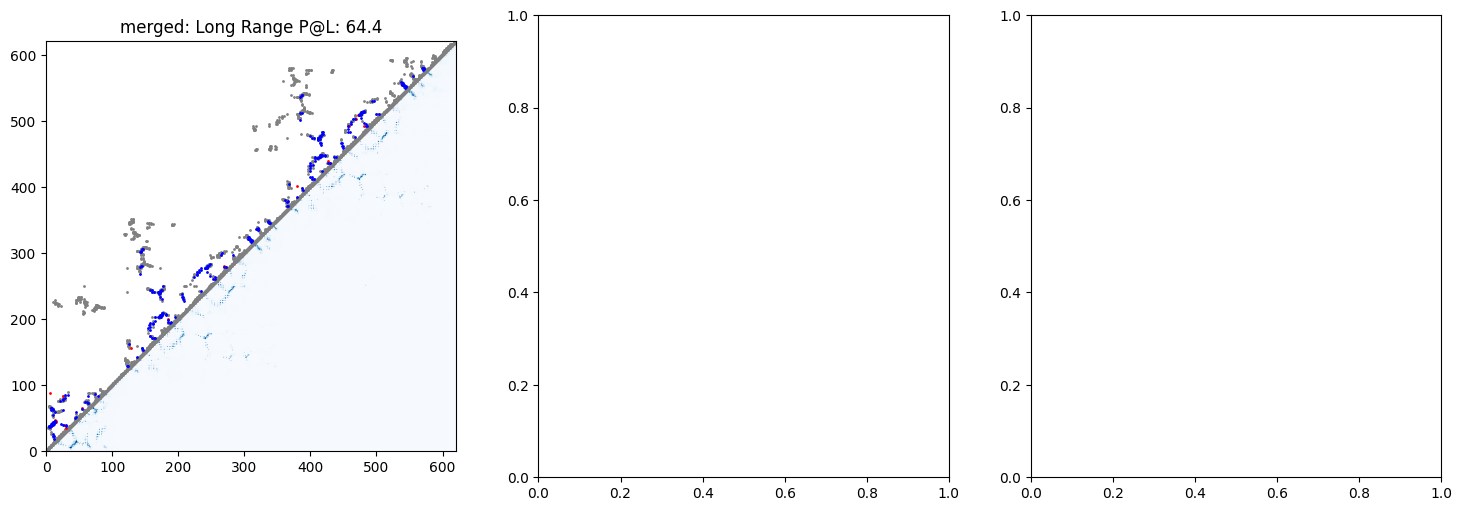

In [43]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = esm2_predictions[name]
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()

### MSA Transformer Predictions

In [44]:
msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().cuda()
msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

In [51]:
msa_transformer_predictions = {}
msa_transformer_results = []
for name, inputs in msas.items():
    inputs = greedy_select(inputs, num_seqs=120) # can change this to pass more/fewer sequences
    msa_transformer_batch_labels, msa_transformer_batch_strs, msa_transformer_batch_tokens = msa_transformer_batch_converter([inputs])
    msa_transformer_batch_tokens = msa_transformer_batch_tokens.to(next(msa_transformer.parameters()).device)
    msa_transformer_predictions[name] = msa_transformer.predict_contacts(msa_transformer_batch_tokens)[0].cpu()
    metrics = {"id": name, "model": "MSA Transformer (Unsupervised)"}
    metrics.update(evaluate_prediction(msa_transformer_predictions[name], contacts[name]))
    msa_transformer_results.append(metrics)
msa_transformer_results = pd.DataFrame(msa_transformer_results)
display(msa_transformer_results)

OutOfMemoryError: ignored

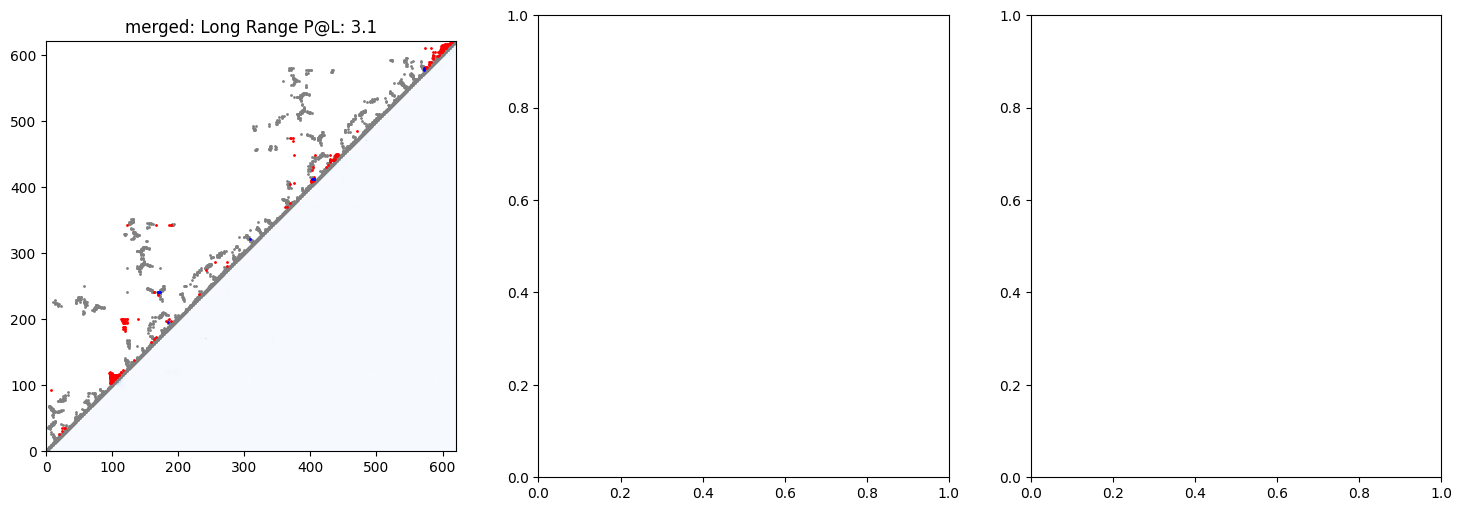

In [50]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
for ax, name in zip(axes, PDB_IDS):
    prediction = msa_transformer_predictions[name]
    target = contacts[name]
    plot_contacts_and_predictions(
        prediction, target, ax=ax, title = lambda prec: f"{name}: Long Range P@L: {100 * prec:0.1f}"
    )
plt.show()

In [ ]:
out = open("predictions.txt","w")
name = PDB_IDS[0]

prediction = msa_transformer_predictions[name]
target = contacts[name]
matrix = prediction.reshape(-1, prediction.shape[-1])
for i in range (0,len(matrix[0])):
  for j in range (i+1,len(matrix[0])):
    out.write(str(i+1)+" "+str(j+1)+" "+str(matrix[i][j]).replace("tensor(","").replace(")","")+"\n")
out.close
#Now we print the top 118 predictions
!sort -grk3 predictions.txt | awk '$1+6<$2' | head -n 750 > predictions_top3l2.txt
!head -n 10 predictions_top3l2.txt

161 190 0.9975
431 453 0.9969
130 166 0.9851
121 129 0.9828
165 194 0.9812
427 453 0.9765
126 162 0.9710
120 128 0.9531
159 188 0.9370
117 132 0.9296


In [ ]:
!sort -grk3 predictions | head -n 750 > predictions_topl.txt